# Testing Human VAE

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import os
import pbdlib as pbd

import networks
import config
from utils import *
import dataloaders

torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
preds = []
gt = []
lens = []
recons = []
for model_types in [
					# 'vae_hmmtorch_usualrecon',
					# 'vae_hmmtorch_crossrecon_nocovcond', 
					# 'vae_hmmtorch_crossrecon_covcond', 
					# 'vae_hmmtorch_meancrossrecon_nocovcond'
					# 'vae_hmmtorch_onlymeancrossrecon_nocovcond_pretrained',
					# 'vae_hmmtorch_onlymeancrossrecon_covcond',
					'mild_hmmtorch_usualrecon',
					# 'mild_hmmtorch_crossrecon_nocovcond', 
					# 'mild_hmmtorch_onlymeancrossrecon_covcond',
					]:
# for model_types in os.listdir('logs/2023/buetepage_20fps'):
	z_dim = 3
	ckpt = f'logs/2023/buetepage_20fps/{model_types}/z{z_dim}/trial0/models/last_ckpt.pth' # input()
	dirname = os.path.dirname(ckpt)
	ckpt = torch.load(ckpt)
	hyperparams = np.load(os.path.join(dirname,'hyperparams.npz'), allow_pickle=True)
	args_ckpt = hyperparams['args'].item()
	ae_config = hyperparams['ae_config'].item()
	
	model = getattr(networks, args_ckpt.model)(**(ae_config.__dict__)).to(device)
	model.load_state_dict(ckpt['model'])
	model.eval()
	hsmm = ckpt['hsmm']
	
	
	test_dataset = dataloaders.buetepage_downsampled.SequenceWindowDataset(args_ckpt.src, train=False, window_length=model.window_size)
	preds_z = []
	gt_z = []
	lens_z = []
	recons_z = []
	mse_error = []
	
	# for i, x in enumerate(test_iterator):
	for a in test_dataset.actidx:
		x, label = test_dataset[a[0]]
		# x, label = x
		# x = x[0]
		# label = label[0]
		x = torch.Tensor(x).to(device)
		_, seq_len, dims = x.shape
		zpost_dist = model(x, dist_only=True)
		# print(zpost_dist.mean.max(), zpost_dist.mean.min())
		assert not torch.any(torch.isnan(zpost_dist.mean))
		assert not torch.any(torch.isinf(zpost_dist.mean))
		# assert not torch.any(torch.isnan(zpost_dist.mean.exp()))
		# assert not torch.any(torch.isinf(zpost_dist.mean.exp()))
		h0 = hsmm[label].forward_variable(demo=zpost_dist.mean[0], marginal=slice(0, z_dim), cpp=False)
		h1 = hsmm[label].forward_variable(demo=zpost_dist.mean[1], marginal=slice(z_dim, 2*z_dim), cpp=False)
		# assert not torch.any(torch.isnan(h0))
		# assert not torch.any(torch.isinf(h0))
		# assert not torch.any(torch.isnan(h1))
		# assert not torch.any(torch.isinf(h1))
		z0_cond = hsmm[label].condition(zpost_dist.mean[1], dim_in=slice(z_dim, 2*z_dim), dim_out=slice(0, z_dim), h=h1, return_cov=False, data_Sigma_in=zpost_dist.covariance_matrix[1])
		z1_cond = hsmm[label].condition(zpost_dist.mean[0], dim_in=slice(0, z_dim), dim_out=slice(z_dim, 2*z_dim), h=h0, return_cov=False, data_Sigma_in=zpost_dist.covariance_matrix[0])
		mu_prior_cond = torch.concat([z0_cond[None], z1_cond[None]])
		x_gen_cond = model._output(model._decoder(mu_prior_cond))
		
		x_gen = model._output(model._decoder(zpost_dist.mean))
		
		preds_z.append(x_gen_cond.detach().cpu().numpy())
		recons_z.append(x_gen.detach().cpu().numpy())
		gt_z.append(x.detach().cpu().numpy())
		lens_z.append(seq_len)
	preds.append(preds_z)
	gt.append(gt_z)
	lens.append(lens_z)
	recons.append(recons_z)

In [3]:
print(preds[0][0].shape)

(2, 1296, 60)


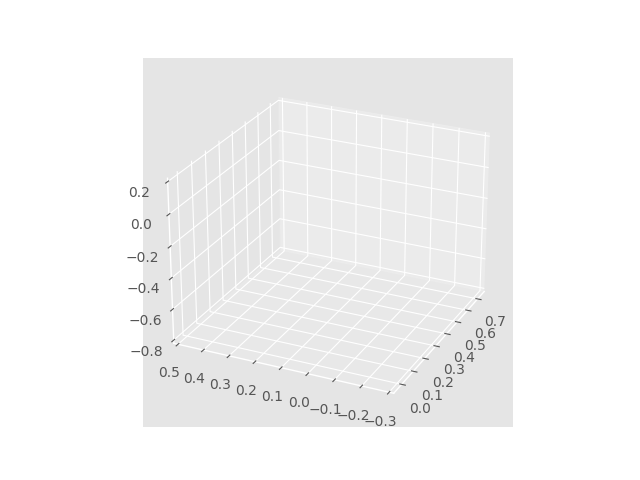

: 

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
from utils import *
import asyncio

fig = plt.figure()
axs = []
i = 1
for z_dim in [3]:#,5,8,10]:
    axs.append(fig.add_subplot(1,1,i, projection='3d'))
    i+=1
    axs[-1].view_init(25, -155)
    axs[-1].set_xlim3d([-0.05, 0.75])
    axs[-1].set_ylim3d([-0.3, 0.5])
    axs[-1].set_zlim3d([-0.8, 0.2])

async def update():
    global ax, preds, gt, test_dataset, recons
    for i in range(len(test_dataset.actidx)):
        for frame_idx in range(lens[0][i]):
            for j in range(1):
                axs[j] = reset_axis(axs[j])
                # axs[j] = visualize_skeleton(axs[j], gt[j][i][0][frame_idx].reshape((40,4,3)), markerfacecolor='r', linestyle='-', alpha=0.5)
                axs[j] = visualize_skeleton(axs[j], gt[j][i][1][frame_idx].reshape((model.window_size,model.num_joints,3)), markerfacecolor='b', linestyle='-', alpha=0.5)
                # axs[j] = visualize_skeleton(axs[j], preds[j][i][0][frame_idx].reshape((40,4,3)), markerfacecolor='m', linestyle='-', alpha=0.5)
                axs[j] = visualize_skeleton(axs[j], preds[j][i][1][frame_idx].reshape((model.window_size,model.num_joints,3)), markerfacecolor='c', linestyle='--', alpha=0.5)
                # axs[j] = visualize_skeleton(axs[j], preds[j][i][0][frame_idx].reshape((40,4,3)), markerfacecolor='m', linestyle='-', alpha=0.5)
                axs[j] = visualize_skeleton(axs[j], recons[j][i][1][frame_idx].reshape((model.window_size,model.num_joints,3)), markerfacecolor='m', linestyle='-', alpha=0.5)
            fig.canvas.draw_idle()
            fig.canvas.flush_events()
            await asyncio.sleep(0.001)
loop = asyncio.get_event_loop()
loop.create_task(update());
